In [ ]:
# Install required packages
# %pip install nbformat

# Imports

%run Cargar_datos.ipynb
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
%matplotlib inline

# Carga
# PATH = "../../Base_de_datos.csv"   
# df = pd.read_csv(PATH)
df_original = df.copy()  # guarda copia

df.head(25)

Shape: (2007, 13)


,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0
5,505,Dog,Labrador,70,Brown,Large,20.986261,0,0,87,301,1,0
6,506,Bird,Parakeet,169,Brown,Small,10.902613,1,0,70,440,1,0
7,507,Cat,Siamese,13,Orange,Large,7.252683,1,0,3,137,0,1
8,508,Bird,Parakeet,49,Brown,Medium,24.597598,1,1,69,405,0,0
9,509,Bird,Parakeet,60,Gray,Large,7.295994,0,0,73,231,1,0


# 🕵️ Exploración inicial de datos

[Link del dataset original](https://www.kaggle.com/datasets/rabieelkharoua/predict-pet-adoption-status-dataset/data)

### ℹ️ Descripción general de los datos:

Este es un dataset de Kaggle con datos de mascotas en adopción, el cuál es sintético, recolectado en un periodo específico de tiempo con propósitos educacionales. 

> Si bien esto **no lo hace ideal para generalizar el comportamiento de las adopciones**, termina siendo ideal para proyectos de Machine Learning o Data Science con interés de aprender, predecir y entender tendencias de adopciones. 

Estos datos se pueden usar para:

- Modelamiento predictivo para determinar la adoptabilidad de una mascota

- Análisis de impacto de varios factores en las tasas de adopción

- Desarrollo de estrategias para incrementar las adopciones.

In [160]:
# Porcentaje de nulos por columna
missing = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
display(missing)


PetID                 0.0
PetType               0.0
Breed                 0.0
AgeMonths             0.0
Color                 0.0
Size                  0.0
WeightKg              0.0
Vaccinated            0.0
HealthCondition       0.0
TimeInShelterDays     0.0
AdoptionFee           0.0
PreviousOwner         0.0
AdoptionLikelihood    0.0
dtype: float64

### ⛔ **No hay nulos en el dataset**

### 📖 Caracterización de los datos: 

categóricos, numéricos, ordinales, nominales, dicotómicos, politómicos:



1. PetID: Unique identifier for each pet. -> No sirve, se borra

2. PetType: Type of pet (e.g., Dog, Cat, Bird, Rabbit). -> Categorico nominal politómico

3. Breed: Specific breed of the pet. -> Categórico nominal politómico

4. AgeMonths: Age of the pet in months. -> numérico discreto

5. Color: Color of the pet. -> categórico nominal politómico (podría ser ordinal si se ordena de más oscuro a más claro)

6. Size: Size category of the pet (Small, Medium, Large). -> Categórica ordinal politómica

7. WeightKg: Weight of the pet in kilograms. -> numérico continuo

8. Vaccinated: Vaccination status of the pet (0 - Not vaccinated, 1 - Vaccinated). -> categórica dicotómica

9. HealthCondition: Health condition of the pet (0 - Healthy, 1 - Medical condition). -> categórica dicotómica

10. TimeInShelterDays: Duration the pet has been in the shelter (days). -> numérica discreta

11. AdoptionFee: Adoption fee charged for the pet (in dollars). -> numérica discreta

12. PreviousOwner: Whether the pet had a previous owner (0 - No, 1 - Yes). ->  categórica dicotómica

13. AdoptionLikelihood: Likelihood of the pet being adopted (0 - Unlikely, 1 - Likely). -> categórica dicotómica (variable objetivo)


In [161]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               2007 non-null   int64  
 1   PetType             2007 non-null   object 
 2   Breed               2007 non-null   object 
 3   AgeMonths           2007 non-null   int64  
 4   Color               2007 non-null   object 
 5   Size                2007 non-null   object 
 6   WeightKg            2007 non-null   float64
 7   Vaccinated          2007 non-null   int64  
 8   HealthCondition     2007 non-null   int64  
 9   TimeInShelterDays   2007 non-null   int64  
 10  AdoptionFee         2007 non-null   int64  
 11  PreviousOwner       2007 non-null   int64  
 12  AdoptionLikelihood  2007 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 204.0+ KB


None

### 🔩 Eliminación, conversión y corrección de variables

In [162]:
#  columnas a eliminar
to_drop = ['PetID']
for col in to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
print("Dropped:", to_drop)


Dropped: ['PetID']


In [163]:
# Variables categóricas y binarias
cat_cols = ['PetType','Breed','Color','Size']
bin_cols = ['Vaccinated','HealthCondition','PreviousOwner','AdoptionLikelihood']  # target ya es 0/1

# Convertir a category
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Asegurar target entero 0/1
df['AdoptionLikelihood'] = df['AdoptionLikelihood'].astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PetType             2007 non-null   category
 1   Breed               2007 non-null   category
 2   AgeMonths           2007 non-null   int64   
 3   Color               2007 non-null   category
 4   Size                2007 non-null   category
 5   WeightKg            2007 non-null   float64 
 6   Vaccinated          2007 non-null   int64   
 7   HealthCondition     2007 non-null   int64   
 8   TimeInShelterDays   2007 non-null   int64   
 9   AdoptionFee         2007 non-null   int64   
 10  PreviousOwner       2007 non-null   int64   
 11  AdoptionLikelihood  2007 non-null   int64   
dtypes: category(4), float64(1), int64(7)
memory usage: 134.3 KB


## 🔎📑📊 Exploración de datos (EDA)

In [164]:
# info básica 
display(df.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PetType,2007,4,Dog,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Breed,2007,7,Rabbit,493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeMonths,2007.0,NaN,NaN,NaN,92.279522,52.148363,1.0,48.0,94.0,138.0,179.0
Color,2007,5,White,420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Size,2007,3,Medium,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeightKg,2007.0,NaN,NaN,NaN,15.705776,8.327749,1.018198,8.730396,15.925416,22.73718,29.995628
Vaccinated,2007.0,NaN,NaN,NaN,0.701046,0.457914,0.0,0.0,1.0,1.0,1.0
HealthCondition,2007.0,NaN,NaN,NaN,0.196313,0.397307,0.0,0.0,0.0,0.0,1.0
TimeInShelterDays,2007.0,NaN,NaN,NaN,43.974091,25.740253,1.0,21.0,45.0,66.0,89.0
AdoptionFee,2007.0,NaN,NaN,NaN,249.142003,142.88704,0.0,127.0,242.0,375.0,499.0


### 📈 Análisis univariable

,mean,std,min,25%,50%,75%,max
AgeMonths,92.279522,52.148363,1.000000,48.000000,94.000000,138.00000,179.000000
WeightKg,15.705776,8.327749,1.018198,8.730396,15.925416,22.73718,29.995628
Vaccinated,0.701046,0.457914,0.000000,0.000000,1.000000,1.00000,1.000000
HealthCondition,0.196313,0.397307,0.000000,0.000000,0.000000,0.00000,1.000000
TimeInShelterDays,43.974091,25.740253,1.000000,21.000000,45.000000,66.00000,89.000000
AdoptionFee,249.142003,142.887040,0.000000,127.000000,242.000000,375.00000,499.000000
PreviousOwner,0.301943,0.459215,0.000000,0.000000,0.000000,1.00000,1.000000
AdoptionLikelihood,0.328351,0.469730,0.000000,0.000000,0.000000,1.00000,1.000000


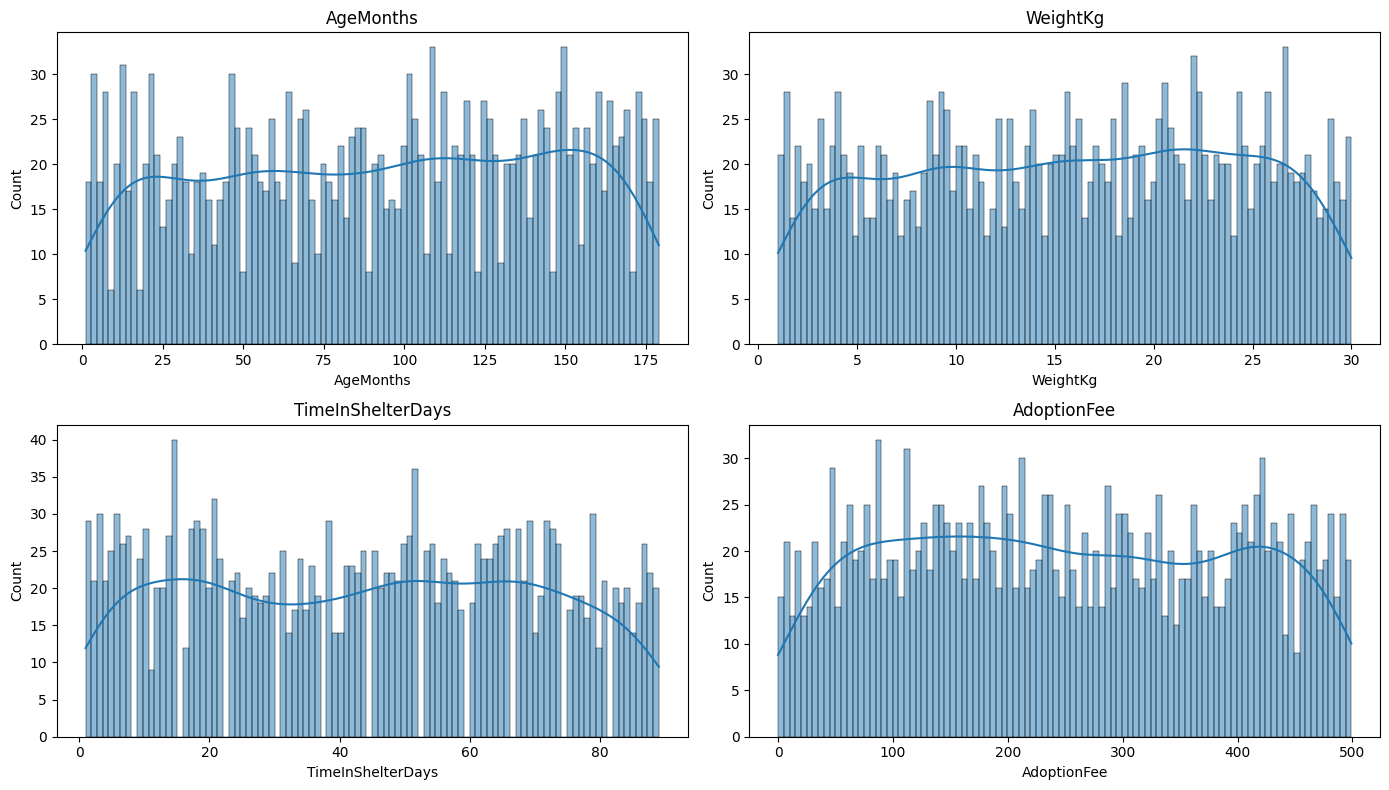

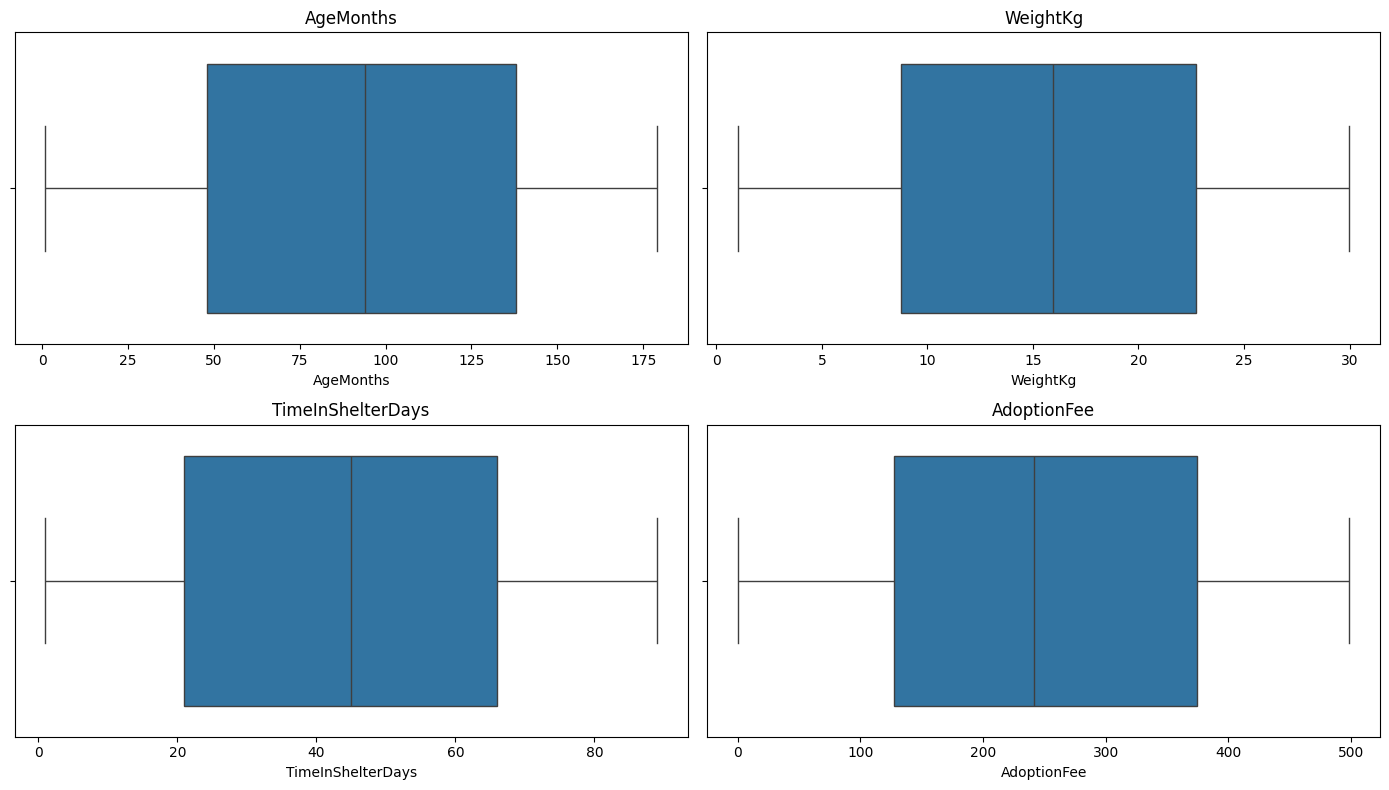

---- PetType ----


PetType
Dog       522
Cat       505
Rabbit    493
Bird      487
Name: count, dtype: int64

---- Breed ----


Breed
Rabbit              493
Parakeet            487
Siamese             253
Persian             252
Labrador            193
Poodle              167
Golden Retriever    162
Name: count, dtype: int64

---- Color ----


Color
White     420
Orange    409
Gray      400
Black     395
Brown     383
Name: count, dtype: int64

---- Size ----


Size
Medium    714
Small     663
Large     630
Name: count, dtype: int64

In [165]:
# Estadísticas numéricas
display(df.select_dtypes(include=[np.number]).describe().T.drop(columns="count"))

# Histogramas para variables numéricas
num_cols = ['AgeMonths','WeightKg','TimeInShelterDays','AdoptionFee']
num_cols = [c for c in num_cols if c in df.columns]
plt.figure(figsize=(14,8))
for i,col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.histplot(df[col].dropna(), kde=True, bins=100)
    plt.title(col)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(14,8))
for i,col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Para variables categóricas: value_counts (top N)
for c in cat_cols:
    if c in df.columns:
        print("----", c, "----")
        display(df[c].value_counts().head(10))


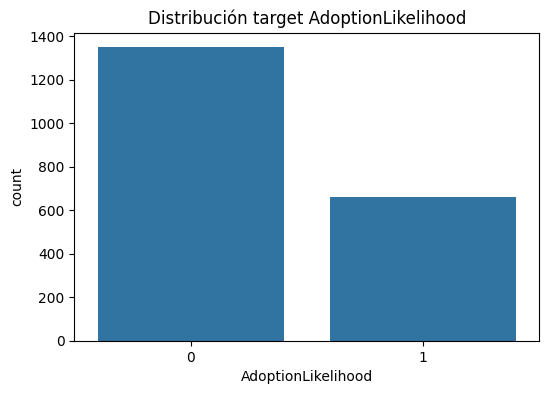

In [166]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.countplot(x='AdoptionLikelihood', data=df)
plt.title('Distribución target AdoptionLikelihood')
plt.show()

# Conteos por PetType
# plt.figure(figsize=(8,4))
# sns.countplot(x='PetType', data=df, order=df['PetType'].value_counts().index)
# plt.title('PetType counts')
# plt.xticks(rotation=45)
# plt.show()


La diferencia entre mascotas adoptadas y sin adoptar en el dataset es de 1 a 3 (un 33% aprox son adoptadas, un 66% están sin adoptar)

In [167]:
for col in num_cols:
    s = df[col].dropna()
    print(col, " skew:", round(s.skew(),3), " kurtosis:", round(s.kurtosis(),3))


AgeMonths  skew: -0.072  kurtosis: -1.214
WeightKg  skew: -0.062  kurtosis: -1.184
TimeInShelterDays  skew: 0.004  kurtosis: -1.211
AdoptionFee  skew: 0.045  kurtosis: -1.198


In [168]:
# Tipos y conteo de variables
print("Shape:", df.shape)
display(df.dtypes)
display(df.nunique().sort_values(ascending=False).head(50))

# Target balance
display(df['AdoptionLikelihood'].value_counts(dropna=False))
display((df['AdoptionLikelihood'].value_counts(normalize=True)*100).round(2))


Shape: (2007, 12)


PetType               category
Breed                 category
AgeMonths                int64
Color                 category
Size                  category
WeightKg               float64
Vaccinated               int64
HealthCondition          int64
TimeInShelterDays        int64
AdoptionFee              int64
PreviousOwner            int64
AdoptionLikelihood       int64
dtype: object

WeightKg              2007
AdoptionFee            493
AgeMonths              179
TimeInShelterDays       89
Breed                    7
Color                    5
PetType                  4
Size                     3
HealthCondition          2
Vaccinated               2
PreviousOwner            2
AdoptionLikelihood       2
dtype: int64

AdoptionLikelihood
0    1348
1     659
Name: count, dtype: int64

AdoptionLikelihood
0    67.16
1    32.84
Name: proportion, dtype: float64

In [169]:
# cuentas de valores distintos por columna
print(df.nunique(dropna=False))

# listas de valores distintos por columna 
distincts = {
    c: (df[c].dropna().unique().tolist()
        if df[c].nunique() <= 50
        else df[c].dropna().unique()[:50].tolist() + ["..."])
    for c in df.columns
}
for c, vals in distincts.items():
    print(f"{c} ({len(vals)}): {vals}")

PetType                  4
Breed                    7
AgeMonths              179
Color                    5
Size                     3
WeightKg              2007
Vaccinated               2
HealthCondition          2
TimeInShelterDays       89
AdoptionFee            493
PreviousOwner            2
AdoptionLikelihood       2
dtype: int64
PetType (4): ['Bird', 'Rabbit', 'Dog', 'Cat']
Breed (7): ['Parakeet', 'Rabbit', 'Golden Retriever', 'Labrador', 'Siamese', 'Persian', 'Poodle']
AgeMonths (51): [131, 73, 136, 97, 123, 70, 169, 13, 49, 60, 130, 5, 172, 27, 160, 149, 8, 50, 67, 44, 125, 58, 3, 86, 2, 102, 35, 98, 30, 116, 150, 36, 77, 31, 47, 55, 106, 158, 121, 144, 12, 145, 140, 23, 92, 115, 104, 118, 108, 65, '...']
Color (5): ['Orange', 'White', 'Gray', 'Brown', 'Black']
Size (3): ['Large', 'Medium', 'Small']
WeightKg (51): [5.039767822529515, 16.086726854616735, 2.0762862789067658, 3.339423254344144, 20.49809976164308, 20.986260902397984, 10.90261279164483, 7.252683192048298, 24.5975978

### 🧮📊📉 Análisis bivariable y multivariable

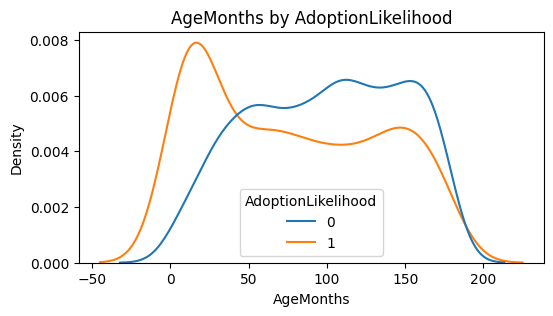

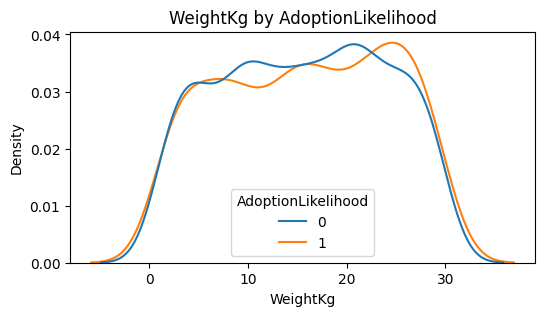

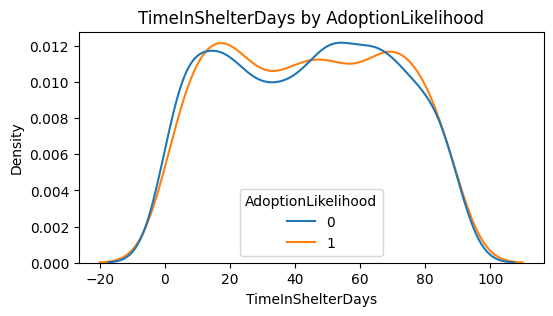

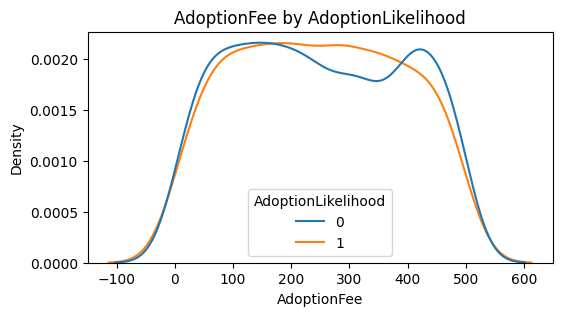

In [170]:
# Proporción de adopción por PetType
# if 'PetType' in df.columns:
#     prop = df.groupby('PetType', observed=False)['AdoptionLikelihood'].mean().sort_values(ascending=False)
#     display((prop*100).round(2))

# Boxplot de TimeInShelterDays por AdoptionLikelihood
# plt.figure(figsize=(8,4))
# sns.boxplot(x='AdoptionLikelihood', y='TimeInShelterDays', data=df)
# plt.title('TimeInShelterDays vs AdoptionLikelihood')
# plt.show()

# Gráficos numéricos por target
for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=df, x=col, hue='AdoptionLikelihood', common_norm=False)
        plt.title(f'{col} by AdoptionLikelihood')
        plt.show()


- Las mascotas con menos de 50 meses tienden a ser más adoptadas
- Las mascotas con más de 100 meses tienden a ser menos adoptadas


In [171]:
# Correlación entre variables numéricas
pd.pivot_table(
    df, 
    values='AdoptionLikelihood', 
    index='PetType', 
    aggfunc='mean',
    observed=False
).sort_values(by='AdoptionLikelihood', ascending=False)*100

,AdoptionLikelihood
PetType,
Dog,46.360153
Bird,30.184805
Cat,28.712871
Rabbit,25.354970



- 46.3% De los perros fueron adoptados
- 30.2% De las aves fueron adoptadas
- 28.7% De los gatos fueron adoptados
- 25.3% De los conejos fueron adoptados


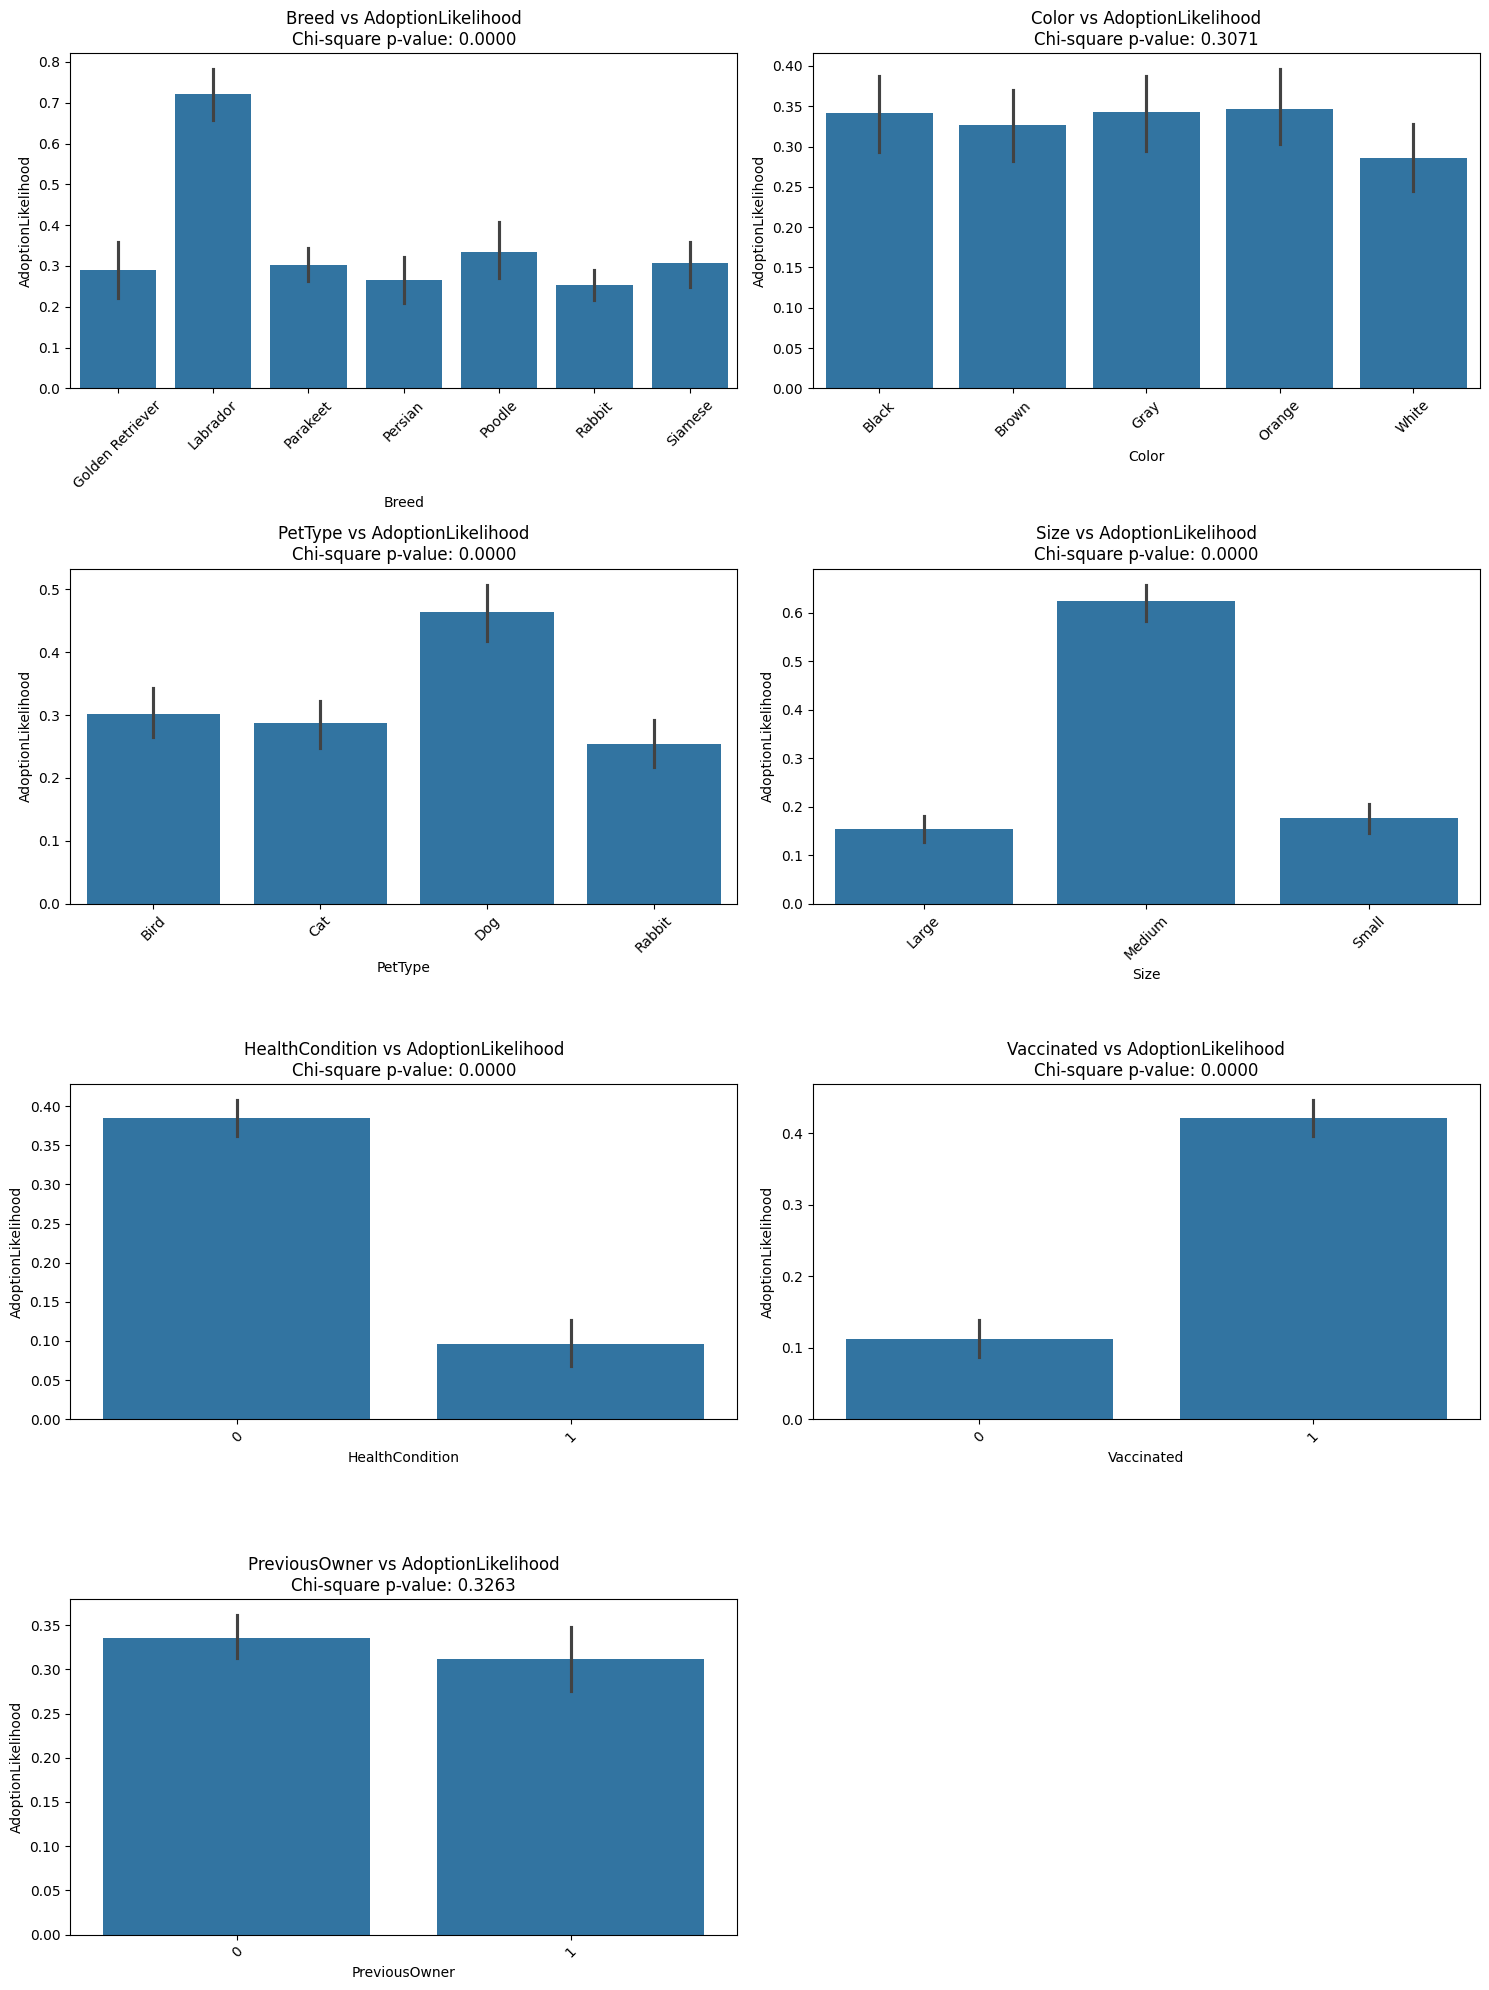


Cramer's V scores:

Breed: 0.2774
Color: 0.0490
PetType: 0.1747
Size: 0.4670
HealthCondition: 0.2427
Vaccinated: 0.3002
PreviousOwner: 0.0219


In [172]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

'''

Para analizar la relación entre estas variables categóricas y 
la variable objetivo AdoptionLikelihood,
podemos crear visualizaciones y realizar pruebas estadísticas.

Este código:

Creará visualizaciones de barras para cada variable vs AdoptionLikelihood
Calculará el p-valor del test chi-cuadrado para evaluar la independencia
Calculará el Cramer's V para medir la fuerza de la asociación
'''

# Asumiendo que tienes un DataFrame llamado 'df'
categorical_vars = ['Breed', 'Color', 'PetType', 'Size', 'HealthCondition', 
                   'Vaccinated', 'PreviousOwner']

# Crear subplots para cada variable
plt.figure(figsize=(15, 20))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(4, 2, i)
    
    # Crear tabla de contingencia y calcular chi-cuadrado
    contingency = pd.crosstab(df[var], df['AdoptionLikelihood'])
    chi2, p_value = chi2_contingency(contingency)[:2]
    
    # Crear gráfico de barras apiladas
    sns.barplot(data=df, x=var, y='AdoptionLikelihood')
    plt.title(f'{var} vs AdoptionLikelihood\nChi-square p-value: {p_value:.4f}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Imprimir el Cramer's V para medir la fuerza de asociación
def cramers_v(var):
    confusion_matrix = pd.crosstab(df[var], df['AdoptionLikelihood'])
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2/min(k-1, r-1))

print("\nCramer's V scores:\n")
for var in categorical_vars:
    score = cramers_v(var)
    print(f"{var}: {score:.4f}")

Luego de revisar la relación entre variables categóricas y la variable objetivo:

- Si p ≈ 0 y Cramer's V > 0.3, **hay relación real y relevante.** 
Las **variables Size y Vaccinated** entran en esta categoría

- Si p ≈ 0 pero Cramer's V < 0.2 → **relación estadísticamente detectable pero débil  (Breed, PetType, HealthCondition).**

- Si p es grande (ej. 0.37 en Color) → **no hay casi evidencia de relación**, y además V confirma que es irrelevante. 
Por lo que **PreviousOwner y Color** parecen no influir mucho en la adoptabilidad



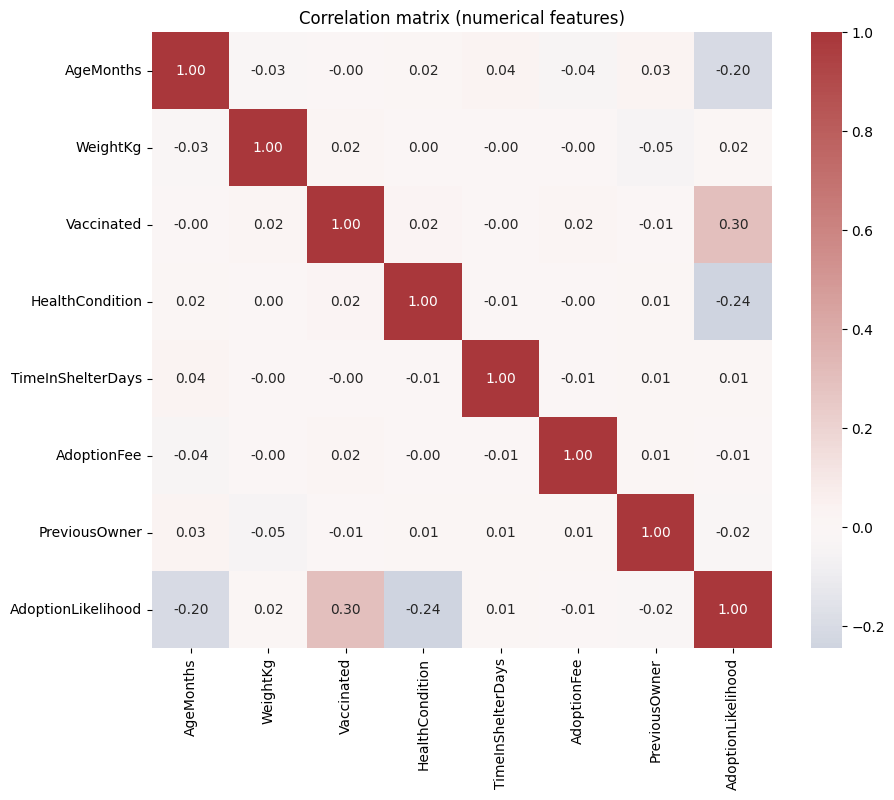

In [173]:
# Correlación entre numéricas (Pearson)
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix (numerical features)')
plt.show()


No parecen haber variables redundantes... Y si se mantiene la variable objetivo, se puede alcanzar a apreciar cierta relación entre algunas variables numéricas como vaccinated, agemonths y health condition


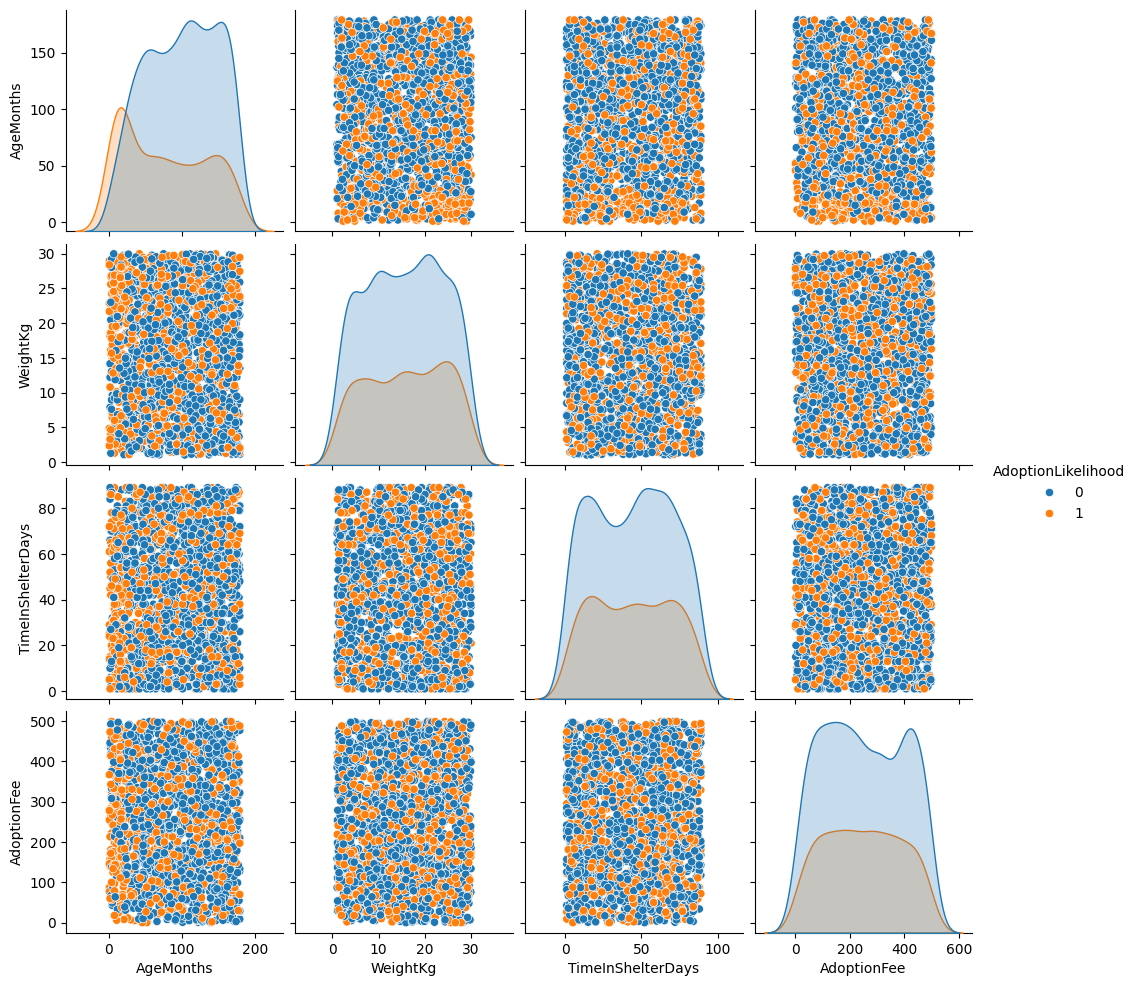

In [174]:
# Pairplot - si pocas columnas numéricas
# sample = df.sample(min(2007, len(df)), random_state=42)
sns.pairplot(df[num_cols + ['AdoptionLikelihood']], hue='AdoptionLikelihood')
plt.show()


### 💡 Conclusiones y posibles consideraciones

- El dataset parece contar con los suficientes patrones para darle funcionamiento a modelos predictivos


In [175]:
display((df.describe(include='all').T).drop(columns=["count","25%","50%","75%","std"]))


,unique,top,freq,mean,min,max
PetType,4,Dog,522,NaN,NaN,NaN
Breed,7,Rabbit,493,NaN,NaN,NaN
AgeMonths,NaN,NaN,NaN,92.279522,1.0,179.0
Color,5,White,420,NaN,NaN,NaN
Size,3,Medium,714,NaN,NaN,NaN
WeightKg,NaN,NaN,NaN,15.705776,1.018198,29.995628
Vaccinated,NaN,NaN,NaN,0.701046,0.0,1.0
HealthCondition,NaN,NaN,NaN,0.196313,0.0,1.0
TimeInShelterDays,NaN,NaN,NaN,43.974091,1.0,89.0
AdoptionFee,NaN,NaN,NaN,249.142003,0.0,499.0


Reglas de validación de datos (sugerencias)

AgeMonths debe ser >= 0 y < 240 (si aparece >1000 es error).

WeightKg > 0 y < 100 (filtrar outliers).

Categorías con muy pocos registros agrupar en 'Other' (ej. razas raras).

Features derivados sugeridos

AgeYears = AgeMonths / 12 (más interpretable).

IsPuppy = AgeMonths < 12 (boolean).

FeePerKg = AdoptionFee / WeightKg (si WeightKg disponible).

ShelterTimeBucket = bucketizado de TimeInShelterDays (0-30,31-90,90+).

YoungAndLight combinando edad y peso.